# 👖 Variational Autoencoders - Fashion-MNIST

In this notebook, we'll walk through the steps required to train your own autoencoder on the fashion MNIST dataset.

The code has been adapted from the excellent [VAE tutorial](https://keras.io/examples/generative/vae/) created by Francois Chollet, available on the Keras website.

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm


# 0. Parameters <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

# 1. Prepare the data <a name="prepare"></a>

In [4]:
# Load the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [5]:
# Preprocess the data

def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [ ]:
# Show some items of clothing from the training set
display(x_train)

# 2. Build the variational autoencoder <a name="build"></a>
Variational Model Structure </br>

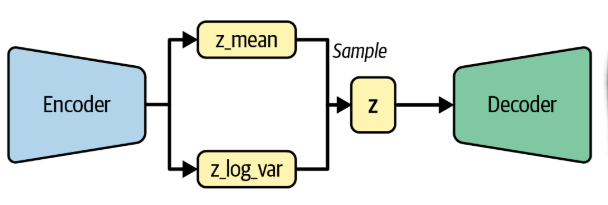

### 2.1 Encoder

In [6]:
class Sampling(layers.Layer):     # We customize a new layer by subclassing the Keras base Layer class and define the call method.
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon   # use the reparameterization trick to return a sample from the normal distribution parameterized by z_mean and z_log_var

In [7]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
#Instead of connecting the Flatten layer directly to the 2D latent space, we con‐nect
#it to layers z_mean and z_log_var.
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)          # use a dense layer to learn z_mean with EMBEDDING_DIM number of parameters, see mmodel structure figure above
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)    # use a dense layer to learn z_log_var with EMBEDDING_DIM number of parameters, see mmodel structure figure above
z = Sampling()([z_mean, z_log_var])                             # sampling in latent space from the normal distri‐bution defined by the parameters z_mean and z_log_var.

# The Keras Model that defines the encoder—a model that takes an input image and
# outputs z_mean, z_log_var, and a sampled point z from the normal distribu‐tion defined by these parameters.
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_1[0][0]']            
                                                                                            

### 2.2 Decoder

**Conv2DTranspose** does the opposite to **Conv2D**, in that it expand tensor, instead of compressing it.
1. **Upsampling**: It starts with an input tensor and increases its spatial dimensions by inserting zeros between the existing data points. This is called upsampling.
2. **Convolution**: It then performs a regular convolution operation on the upsampled tensor, using a learnable kernel, which can extract features from the upsampled data.
3. **Strides and Padding**: Like regular convolutional layers, Conv2DTranspose layers can also have adjustable stride and padding options to control the output size.
4. **Learnable Parameters**: Similar to other layers in a neural network, the parameters of the Conv2DTranspose layer (such as the kernel weights and biases) are learned during the training process.

Output Size
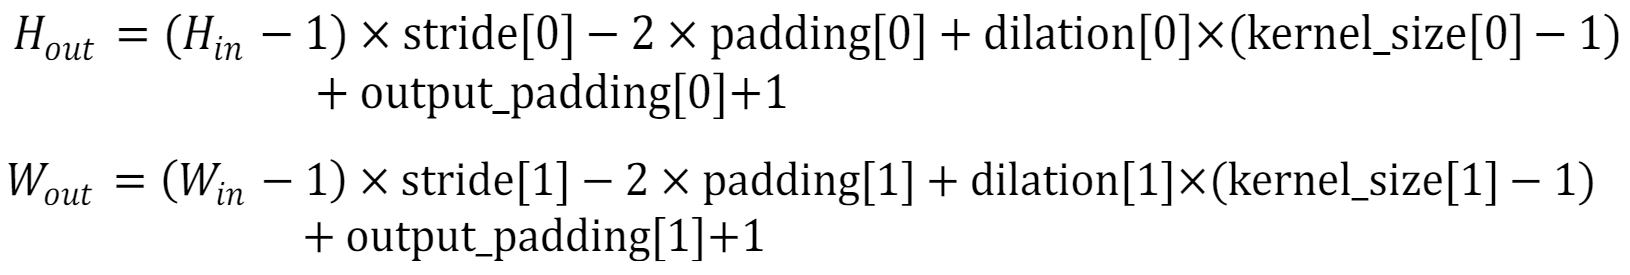

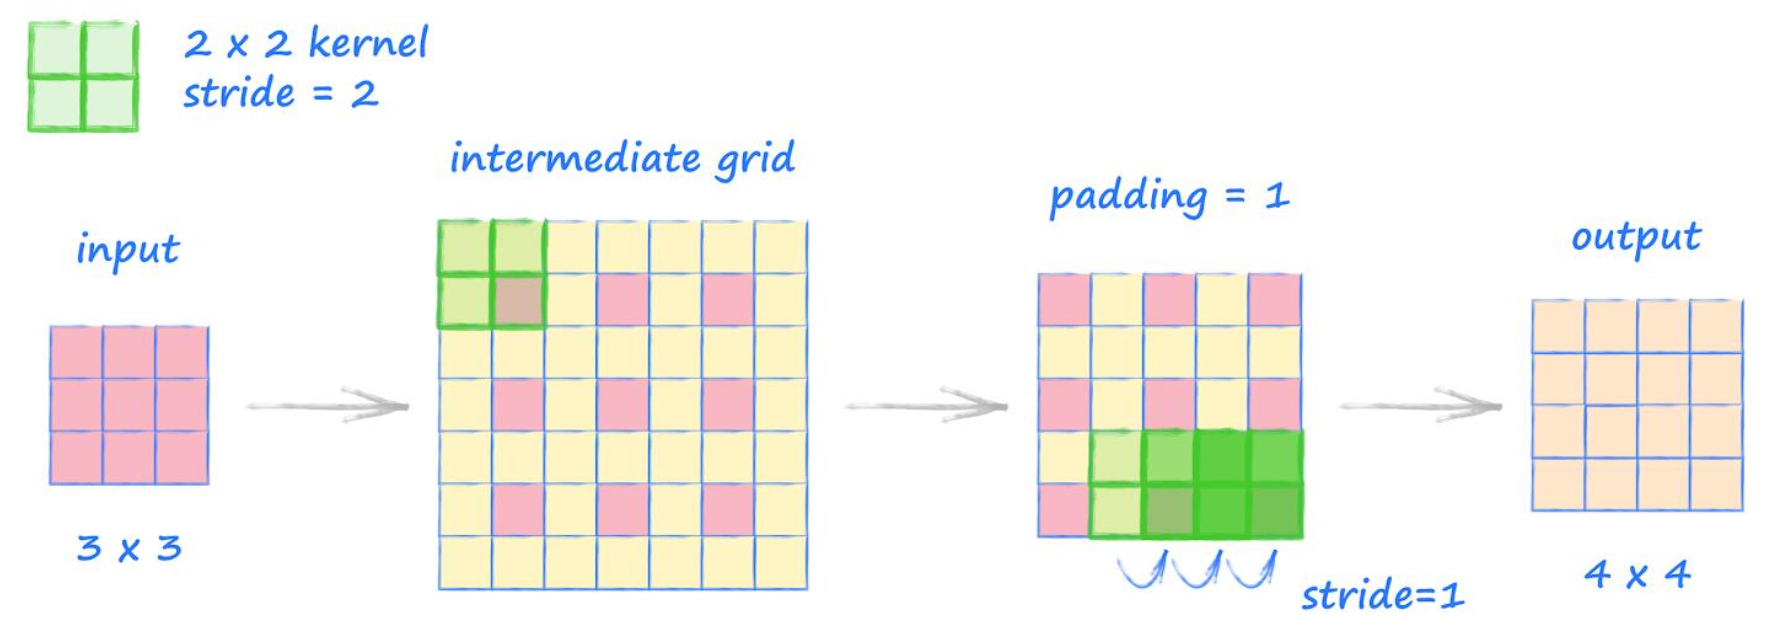


In [8]:
# Decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoder_output = layers.Conv2D(1, (3, 3), strides=1, activation="sigmoid", padding="same",
                               name="decoder_output",)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)        18464 

In [10]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):            # override train_step() to customize fit(), as fit() will call this funciton.
        """Step run during training."""
        with tf.GradientTape() as tape:    # use GradientTape() to calcualte gradients
            z_mean, z_log_var, reconstruction = self(data)                    # Forward pass
            reconstruction_loss = tf.reduce_mean(                             # Caclcualte the loss value
                BETA * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
            )

            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)            # calculate gradient w.r.t weights
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))   # apply gradient to Update weights

        self.total_loss_tracker.update_state(total_loss)                     # Update metrics (includes the metric that tracks the loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}                    # Return a dict mapping metric names to current value

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [11]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

## 3. Train the variational autoencoder <a name="train"></a>

In [12]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [13]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [14]:
vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/5
595/600 [============================>.] - ETA: 0s - total_loss: 160.0551 - reconstruction_loss: 155.5060 - kl_loss: 4.5492

600/600 [==============================] - 15s 11ms/step - total_loss: 159.8650 - reconstruction_loss: 155.3123 - kl_loss: 4.5526 - val_loss: 140.6119 - val_reconstruction_loss: 135.6385 - val_kl_loss: 4.9734
Epoch 2/5
598/600 [============================>.] - ETA: 0s - total_loss: 136.0244 - reconstruction_loss: 131.0599 - kl_loss: 4.9646

600/600 [==============================] - 6s 10ms/step - total_loss: 136.0076 - reconstruction_loss: 131.0435 - kl_loss: 4.9642 - val_loss: 138.1151 - val_reconstruction_loss: 133.2680 - val_kl_loss: 4.8471
Epoch 3/5
597/600 [============================>.] - ETA: 0s - total_loss: 134.2589 - reconstruction_loss: 129.2505 - kl_loss: 5.0085

600/600 [==============================] - 6s 10ms/step - total_loss: 134.2491 - reconstruction_loss: 129.2406 - kl_loss: 5.0087 - val_loss: 136.6615 - val_reconstruction_loss: 131.4139 - val_kl_loss: 5.2476
Epoch 4/5
596/600 [============================>.] - ETA: 0s - total_loss: 133.3694 - reconstruction_loss: 128.3130 - kl_loss: 5.0562

600/600 [==============================] - 6s 10ms/step - total_loss: 133.3696 - reconstruction_loss: 128.3127 - kl_loss: 5.0567 - val_loss: 136.2756 - val_reconstruction_loss: 130.9686 - val_kl_loss: 5.3070
Epoch 5/5
600/600 [==============================] - ETA: 0s - total_loss: 132.7728 - reconstruction_loss: 127.6743 - kl_loss: 5.0984

600/600 [==============================] - 6s 10ms/step - total_loss: 132.7728 - reconstruction_loss: 127.6743 - kl_loss: 5.0984 - val_loss: 135.7204 - val_reconstruction_loss: 130.5375 - val_kl_loss: 5.1830


In [15]:
# Save the final models
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

## 3. Reconstruct using the variational autoencoder <a name="reconstruct"></a>

In [16]:
# Select a subset of the test set
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [17]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(reconstructions)

157/157 [==============================] - 1s 4ms/step
Example real clothing items


array([[[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.        ],
         [0.        ],
         [0.  

Reconstructions


array([[[[3.33236176e-06],
         [3.41091884e-08],
         [8.51020090e-08],
         ...,
         [6.54939569e-09],
         [1.04530606e-07],
         [5.68065188e-05]],

        [[4.71463899e-08],
         [1.29023986e-10],
         [1.64297209e-09],
         ...,
         [8.30623959e-10],
         [7.07093584e-09],
         [7.00689770e-06]],

        [[2.61761297e-08],
         [5.88089022e-10],
         [3.94158803e-08],
         ...,
         [1.21966298e-06],
         [9.48785498e-07],
         [5.78696636e-05]],

        ...,

        [[1.19984174e-08],
         [1.64184041e-10],
         [3.78311213e-08],
         ...,
         [1.29984400e-07],
         [5.92559601e-08],
         [5.93700497e-06]],

        [[8.14136136e-09],
         [8.27730870e-11],
         [5.13058973e-09],
         ...,
         [1.05561759e-09],
         [1.01617714e-09],
         [4.78754998e-07]],

        [[9.55447103e-06],
         [1.60443520e-07],
         [1.12704060e-06],
         ...,
 

## 4. Embed using the encoder <a name="encode"></a>

In [ ]:
# Encode the example images
z_mean, z_var, z = encoder.predict(example_images)

In [ ]:
# Some examples of the embeddings
print(z[:10])

In [ ]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

## 5. Generate using the decoder <a name="decode"></a>

In [ ]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [ ]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

In [ ]:
# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

In [ ]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

## 6. Explore the latent space <a name="explore"></a>

In [ ]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

| ID | Clothing Label |
| :- | :- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

In [ ]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")